# Data Preprocessing

## Importing Data

In [1]:
import pandas as pd

In [2]:
data_fol = "data_reviews/"

In [3]:
x_test = pd.read_csv(data_fol+"x_test.csv")
x_train = pd.read_csv(data_fol+"x_train.csv")
y_train = pd.read_csv(data_fol+"y_train.csv")
# Mods
y_train.columns = ['positive']
x_train.at[:,'length'] = x_train['text'].apply(lambda x: len(x))

## Data Exploration

In [4]:
pd.set_option('display.max_colwidth', 150) 

In [5]:
x_train.describe(include='all')

,website_name,text,length
count,2400,2400,2400.000000
unique,3,2389,NaN
top,amazon,Excellent product for the price.,NaN
freq,800,2,NaN
mean,NaN,NaN,65.344167
std,NaN,NaN,43.132481
min,NaN,NaN,7.000000
25%,NaN,NaN,33.000000
50%,NaN,NaN,56.000000
75%,NaN,NaN,88.000000


### Initial Notes    

- We may consier each review to be unique (despite being one repeated intsance. P(review is repeated)=<<1)
- Reviews are around 70 chars.
- Reviews range from 7 o 336 chars.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

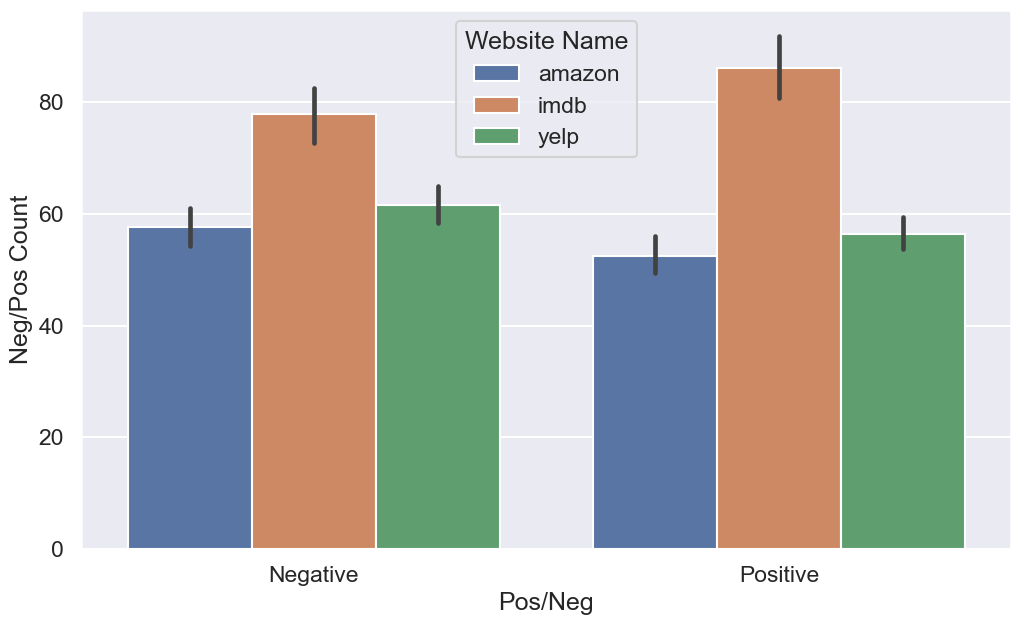

In [7]:
sns.set(context='talk')

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    x=y_train['positive'], 
    y=x_train['length'],
    hue=x_train['website_name'], 
    ax=ax,
)

# Customizing the legend title
ax.legend(title='Website Name')

# Customizing the axis titles
ax.set_ylabel('Neg/Pos Count')
ax.set_xlabel('Pos/Neg')

# Changing the x-axis ticks
ax.set_xticks([0, 1])
ax.set_xticklabels(['Negative', 'Positive'])

plt.show()

### Notes on Website  

The distribution of negative and positive impressions across websites seems balanced. Probably want to stratify accross these when splitting the data.

## Data Cleaning

In [9]:
import spacy
from spacy.language import Language
import numpy as np
from spellchecker import SpellChecker
from spacy.attrs import LOWER, POS
from spacy.tokens import Doc
from sklearn.feature_extraction.text import CountVectorizer
import re

In [10]:
x_train.head(10)

,website_name,text,length
0,amazon,Oh and I forgot to also mention the weird color effect it has on your phone.,76
1,amazon,THAT one didn't work either.,28
2,amazon,Waste of 13 bucks.,18
3,amazon,"Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.",124
4,amazon,None of the three sizes they sent with the headset would stay in my ears.,73
5,amazon,Worst customer service.,23
6,amazon,The Ngage is still lacking in earbuds.,38
7,amazon,It always cuts out and makes a beep beep beep sound then says signal failed.,76
8,amazon,the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!!,67
9,amazon,Very disappointed in AccessoryOne.,34


In [ ]:
stop_words_to_keep = ["n't", "some", "no"]
for word in stop_words_to_keep:
    nlp.Defaults.stop_words.remove(word)

In [125]:
spell = SpellChecker(distance=3)
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def NLP_review(review_text):
    # Remove punctuation except for ! and ?
    clean_text = re.sub(r"[^\w\s!?']", "", review_text)
    # Normalize letter repetition
    clean_text = re.sub(r"(\w)\1{2,}", r"\1\1", clean_text)
    # Take care of ellipsis 
    clean_text = re.sub(r'\.\.\.|…', ' <ELLIPSIS> ', clean_text)
    # Handle em dashes
    clean_text = re.sub(r'--', ' <EMDASH> ', clean_text)
    

    def process_word(w):
        if w.is_stop:
            return ""
        if w.pos_ != "PROPN":
            w = w.lower_
        else:
            w = w.text
        if spell.correction(w):
            w = spell.correction(w)
        return w
        
    clean_text = " ".join([process_word(token) for token in nlp(clean_text)])
    # Normalize spaces
    clean_text = re.sub(r"\s+", " ", clean_text)
    clean_text = clean_text.strip()
    # Separate n't 
    # clean_text = re.sub(r"n't", " n't", clean_text)
    
    return clean_text

In [126]:
NLP_review("Some didn't it gooooood BET some erors in John this setnence. Is SPEAKERPHONE it a good review? Maybe it's a bad onq! No one knows yet")

'some not good bet some errors John sentence speakerphone good review ? maybe bad on ! no knows'

In [127]:
x_train_clean = [NLP_review(rev) for rev in x_train.text.tolist()]
print(x_train_clean[:20])

['oh forgot mention weird color effect phone', 'not work', 'waste 13 bucks', 'product useless charging current charge 2 cellphones planning use', 'sizes sent headset stay ears', 'worst customer service', 'engage lacking barbuda', 'cuts makes beep beep beep sound says signal failed', 'disappointing thing no SPEAKERPHONE ! ! ! !', 'disappointed AccessoryOne', 'basically service bad', 'Bad Choice', 'thing disappoint infra red port idea', 'horrible switch 3 times', 'feels poorly constructed menus difficult navigate buttons recessed difficult push', 'not mistake', 'muddy low quality sound casing wire insert poorly super glued slid', 'advise fooled !', 'not hold charge', 'waste time !']


In [128]:
for x, y in zip(x_train.text[:15], x_train_clean[:15]):
    print(x, "||||", y)
    print("---")

Oh and I forgot to also mention the weird color effect it has on your phone. |||| oh forgot mention weird color effect phone
---
THAT one didn't work either. |||| not work
---
Waste of 13 bucks. |||| waste 13 bucks
---
Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with. |||| product useless charging current charge 2 cellphones planning use
---
None of the three sizes they sent with the headset would stay in my ears. |||| sizes sent headset stay ears
---
Worst customer service. |||| worst customer service
---
The Ngage is still lacking in earbuds. |||| engage lacking barbuda
---
It always cuts out and makes a beep beep beep sound then says signal failed. |||| cuts makes beep beep beep sound says signal failed
---
the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!! |||| disappointing thing no SPEAKERPHONE ! ! ! !
---
Very disappointed in AccessoryOne. |||| disappointed AccessoryOne
---
Basically the 

## Vectorizing

In [129]:
review_vectorizer = CountVectorizer()
x_train_vec = review_vectorizer.fit_transform(x_train_clean)
print(x_train_vec[:30])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 126 stored elements and shape (30, 4183)>
  Coords	Values
  (0, 2487)	1
  (0, 1500)	1
  (0, 2281)	1
  (0, 4070)	1
  (0, 722)	1
  (0, 1198)	1
  (0, 2661)	1
  (1, 2453)	1
  (1, 4131)	1
  (2, 4041)	1
  (2, 8)	1
  (2, 486)	1
  (3, 2819)	1
  (3, 3943)	1
  (3, 623)	1
  (3, 923)	1
  (3, 617)	1
  (3, 593)	1
  (3, 2696)	1
  (3, 3940)	1
  (4, 3328)	1
  (4, 3224)	1
  (4, 1712)	1
  (4, 3473)	1
  (4, 1179)	1
  :	:
  (22, 3693)	1
  (22, 1849)	1
  (22, 4058)	1
  (23, 1349)	1
  (23, 3815)	1
  (23, 3897)	1
  (23, 2348)	1
  (23, 2836)	1
  (24, 2819)	1
  (24, 1045)	1
  (24, 2501)	1
  (24, 2955)	1
  (24, 274)	1
  (25, 36)	1
  (25, 1124)	1
  (26, 64)	1
  (26, 1986)	1
  (27, 2661)	1
  (27, 2453)	1
  (27, 3504)	1
  (27, 2464)	1
  (27, 1755)	1
  (28, 1064)	1
  (29, 2955)	1
  (29, 1955)	1


In [89]:
x_train_vec.shape

(2400, 4202)

In [26]:
review_vectorizer.get_feature_names_out()

array(['010', '10', '100', ..., 'zero', 'zillion', 'zombie'], dtype=object)

In [55]:
np.array(word_doc_occurrences)[0]

array([ 2, 20,  3, ...,  6,  1,  1], dtype=int64)

In [131]:
review_vectorizer.get_feature_names_out()[word_freqs_idcs][:50]

array(['not', 'good', 'great', 'movie', 'phone', 'film', 'place', 'food',
       'like', 'service', 'time', 'bad', 'best', 'no', 'love', 'quality',
       'excellent', 'product', 'better', 'some', 'recommend', 'work',
       'works', 'nice', 'way', 'use', 'sound', 'headset', 'think',
       'disappointed', 'battery', 'pretty', 'little', 'characters',
       'price', 'acting', 'came', 'case', 'ear', 'definitely', 'worst',
       'got', 'right', 'amazing', 'waste', 'movies', 'money', 'going',
       'thing', 'minutes'], dtype=object)

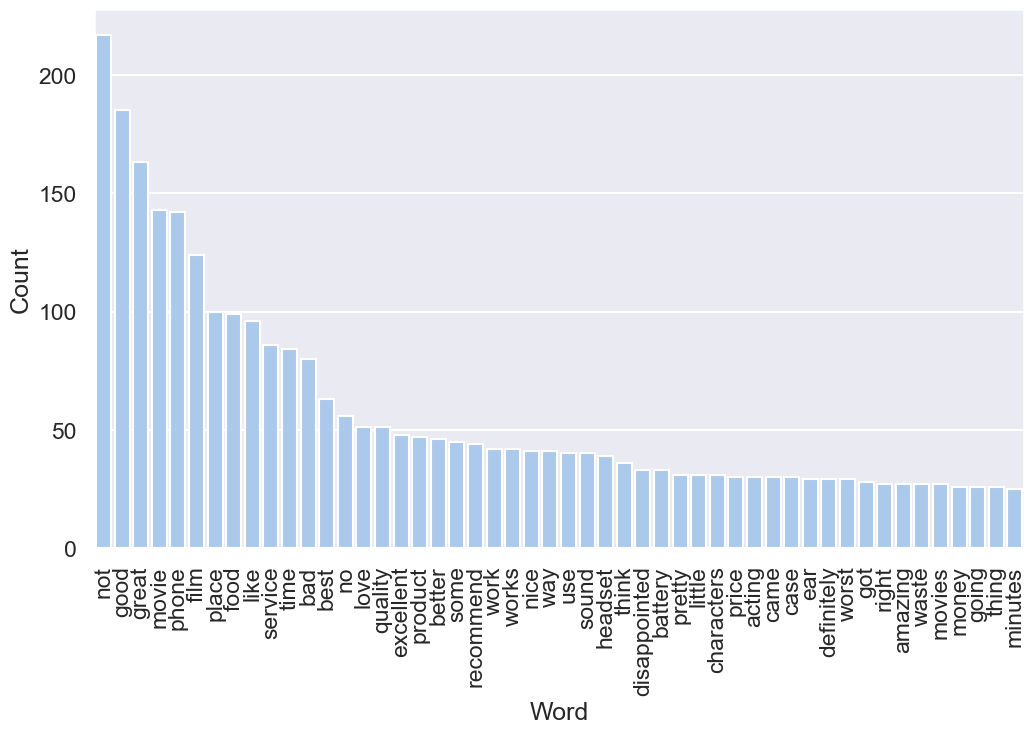

In [132]:
word_doc_occurrences = np.array(x_train_vec.sum(axis=0))[0]
word_freqs_idcs = np.argsort(word_doc_occurrences)[::-1]

sns.set(context='talk', palette="pastel")

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    x=review_vectorizer.get_feature_names_out()[word_freqs_idcs][:50], 
    y=word_doc_occurrences[word_freqs_idcs][:50],
    ax=ax,
)

# Customizing the axis titles
ax.set_ylabel('Count')
ax.set_xlabel('Word')

# Changing the x-axis ticks
ax.tick_params(axis='x', rotation=90)
plt.show()

## Visualizing

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()